In [1]:
import re
import statistics as stat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from difflib import SequenceMatcher
import scrapping_with_selenium as sc  # scrapping_with_selenium: past project which scrapes data from wuzzuf(check it in my past repo)

In [10]:
# the function which scrapes the data for the first 150 pages
table = sc.scraper("Data", 110, ["Analyst", "Data Engineer", "Data Scientist", "Bi", "Business Intelligence"])

In [11]:
table.to_csv("D:\Projects\Data Roles Market\df.csv", index = False)

In [32]:
# read the csv file 
df = pd.read_csv("D:\Projects\Data Roles Market\df.csv")

In [33]:
# only keep job titles that contains(Data, Analyst & Bi)
df2 = df.copy()
df2 = df2[
df2["job_title"].str.contains("Data") |
df2["job_title"].str.contains("Analyst") |
df2["job_title"].str.contains("BI")
].copy()

In [35]:
# create a list of our conditions
conditions = [
df2["job_title"].str.contains("Analyst") | df2["job_title"].str.contains("Analysis") ,
df2["job_title"].str.contains("BI"),
df2["job_title"].str.contains("Engineer"),
df2["job_title"].str.contains("Scientist")
]

# create a list of the values we want to assign for each condition
values = ['data analyst', 'bi developer', 'data engineer', 'data scientist']

# create a new column and use np.select to assign values to it using our lists as arguments
df2['roles'] = np.select(conditions, values)
df2 = df2[df2.roles.isin(values) == True]

In [36]:
# extract cities only
df2["location"] = df2["location"].map(lambda x: x.split(',')[0])

In [37]:
# clean companies names & extract experience range
df2["company"] = df2["company"].str.replace(" -", "")
df2["experience"] = df2["experience"].str.replace(" ", "")
df2["experience"] = df2["experience"].str.findall(".(.+?)Y")
df2["experience"] = [''.join(map(str, l)) for l in df2["experience"]]

In [38]:
conditions = [
df2["experience"].str.contains("^0.*"),
df2["experience"].str.contains("^1.*"),
df2["experience"].str.contains("^[23].*"),
df2["experience"].str.contains("^[45].*"),
df2["experience"].str.contains("^[67].*")
]

values = ['entry level', 'junior', 'mid level', 'senior', 'team lead']

df2['levels'] = np.select(conditions, values)

In [39]:
def clean_salaries(df, rol, lst):
        
        conds=[
        (df['roles'] == rol) &
        ((df["salaries"].str.contains("Confidential")) | (df["salaries"].str.contains("Male")) | (df["salaries"].str.contains("Females"))) &
        (df['levels'] == 'entry level'),

        (df['roles'] == rol) &
        ((df["salaries"].str.contains("Confidential")) | (df["salaries"].str.contains("Male")) | (df["salaries"].str.contains("Females"))) &
        (df['levels'] == 'junior'),

        (df['roles'] == rol) &
        ((df["salaries"].str.contains("Confidential")) | (df["salaries"].str.contains("Male")) | (df["salaries"].str.contains("Females"))) &
        (df['levels'] == 'mid level'),

        (df['roles'] == rol) &
        ((df["salaries"].str.contains("Confidential")) | (df["salaries"].str.contains("Male")) | (df["salaries"].str.contains("Females"))) &
        (df['levels'] == 'senior'),

        (df['roles'] == rol) &
        ((df["salaries"].str.contains("Confidential")) | (df["salaries"].str.contains("Male")) | (df["salaries"].str.contains("Females"))) &
        (df['levels'] == 'team lead')
        ]

        for _ in range(len(conds)):
                df['salaries'] = np.where(conds[_], lst[_], df["salaries"])


In [40]:
# replace confidential with avg market salaries lists
sal = {
    "data analyst":[6000, 8000, 10950, 28500, 28500],
    "bi developer":[5625, 8550, 10000, 15000, 20000],
    "data engineer":[9000, 10375, 23000, 30000, 47000],
    "data scientist":[9400, 11000, 19200, 39584, 67815]
}

for i in sal:
    clean_salaries(df2, i, sal[i])        

In [41]:
# replace ("number" To "number") expression, to only mean value
df2["salaries"] = df2["salaries"].apply(lambda salary: re.findall((r"\d+"), salary) if type(salary) == str else salary)
df2["salaries"] = df2["salaries"].apply(lambda salary: list(map(int, salary)) if type(salary) == list else salary)
df2["salaries"] = df2["salaries"].apply(lambda salary: stat.mean(salary) if type(salary) == list else salary)
df2["salaries"] = df2["salaries"].round()

In [23]:
# def is_string_similar(s1: str , s2: str, threshold: float = 0.8):
#    return SequenceMatcher(a = s1.lower(), b = s2.lower()).ratio() >= threshold

In [24]:
# def clean_skills(df, keys):
#     for k in keys:
#         for s in df.skill:
#             if  is_string_similar(s, k, 0.65):
#                 df.skill = df.skill.str.replace(s, k)

In [46]:
# # keep only this list of skills
# skills_keywords= ['Tableau',  'python', 'word', 'machine learning', 'neural networks', 'Excel',
# 'powerpoint', 'r', 'slack', 'coding', 'looker', 'hadoop', 'AWS', 'spark', 'Statistics', 
# 'outlook', 'azure', 'jira', 'twilio', 'SQL Server', 'snowflake', 'warehousing', 'scrum',
# 'power bi', 'shell', 'linux', 'sharepoint', 'devops', 'c#', 'visio', 'SSRS', 'Oracle',
# 'javascript', 'vba', 'java', 'spreadsheets', '.NET', 'postgres', 'spss', 'SSIS',
# 'Office', 'scala', 'alteryx', 'github', 'English', 'HiveQl', 'Arabic', 'German']

# clean_skills(df2, skills_keywords)

In [47]:
# continue the list of conditions
conditions = [
df2["skill"].str.contains("(?i)excel") | df2["skill"].str.contains("(?i)office") | df2["skill"].str.contains("(?i)Accounting"),
df2["skill"].str.contains("(?i)power bi") | df2["skill"].str.fullmatch("(?i)bi"),
df2["skill"].str.contains("(?i)sql server") | df2["skill"].str.fullmatch("(?i)ssis"),
df2["skill"].str.fullmatch("(?i)sql"),
df2["skill"].str.contains("(?i)computer science") | df2["skill"].str.fullmatch("(?i)coding"),
df2["skill"].str.fullmatch("(?i)Tableau"),
df2["skill"].str.fullmatch("(?i)Statistics"),
df2["skill"].str.fullmatch("(?i)python"),
df2["skill"].str.contains("(?i)spark")
]

values = ['excel', 'power bi', 'sql server', 'sql', 'programming', 'tableau', 'Statistics', 'python', 'spark']

df2['skill'] = np.select(conditions, values)
df2 = df2[df2.skill.isin(values) == True]

In [48]:
df1_g = df.groupby(["skill"], as_index=False)["job_id"].count()
df2_g = df2.groupby(["skill"], as_index=False)["job_id"].count()


# EDA

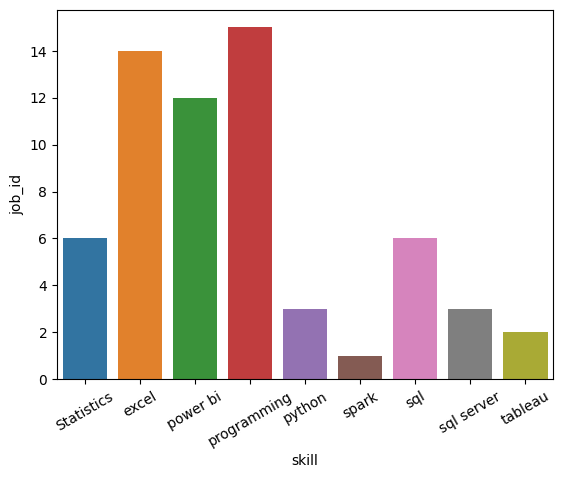

In [59]:
ax = sns.barplot(x= df2_g.skill, y= df2_g.job_id)
ax.tick_params(axis='x', rotation=30)